# Transverse Beam Distribution 

The ultimate goal of the DA studies is to link dynamic aperture to losses in operation. This requires to work with a realistic beam distribution. A priori it is unknown which distribution is existing in the real machine. In [[1]], it is shown that between 1.9% and 3.6% of the beam content is at amplitudes of $4\,\sigma$. Thus, we want to find a distribution which is compatible with this demand. Hence, in this notebook we are evaluating the integral 

$$  T(\mathcal{S}) = 2\, \int_{\mathcal{S}}^{\infty} \rho(x) \, dx \, .$$

Where $\mathcal{S}$ is the lower bound of the amplitude at which the tail content should be considered (in the aforementioned example $4\,\sigma$ and $\rho(x)$ is the transverse particle density function. The factor of two arises from the fact that the measurements are done with both collimator jaws, hence on both sides.

[1]: http://cds.cern.ch/record/1447801/files/CERN-THESIS-2012-046.pdf?subformat=pdfa

## Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy import integrate
from scipy.special import erf, erfc

import pandas as pd
from pandas import HDFStore, DataFrame

from sixdesk.da import * 

In [2]:
def prepare_pcolormesh(x,y,z):
    '''Preparing the colormesh for pcolormesh plot'''
    x=np.unique(x)
    y=np.unique(y)
    X,Y = np.meshgrid(y,x)
    Z   = z.reshape(len(x),len(y))
    return Y,X,Z

## Single Gaussian

A single Gaussian distribution is given by:

$$  \rho_{G}(x) = \frac{1}{\sqrt{2 \, \pi} \, \sigma} \, \exp \left( - \frac{1}{2} \left[\frac{x-\mu}{\sigma}\right]^2 \right)  \, .$$


In [3]:
def gaussian(x,mux,sigx):
    '''Simple 1D Gaussian'''
    return (1./(sigx*np.sqrt(2*np.pi))*np.exp(-(0.5)*((x-mux)/sigx)**2))

def integrate_gauss(mux,sigx,boundaries,moment=0):
    def g(x):
        return gaussian(x,mux,sigx)*x**moment
    
    return integrate.nquad(g,boundaries)

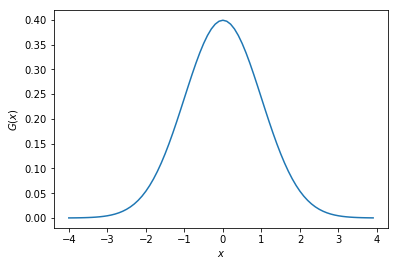

In [4]:
_x = np.arange(-4,4,0.1)
plt.plot(_x,gaussian(_x,0,1))
plt.xlabel(r'$x$')
plt.ylabel(r'$G(x)$')
plt.show()

Check if the integral is 1 and the second order moment corresponds to $\sigma^2$

In [28]:
_data = []
for _sigma in [1,2,3]:
    _int = integrate_gauss(0,_sigma,[[-np.inf,np.inf]])
    _std = integrate_gauss(0,_sigma,[[-np.inf,np.inf]],moment=2)
    _data.append([_sigma,_int[0],_std[0]])

pd.DataFrame(_data, columns=['sigma','integral','variance'])

,sigma,integral,variance
0,1,1.0,1.0
1,2,1.0,4.0
2,3,1.0,9.0


What is the tail content of a Gaussian distribution?

In [26]:
2*integrate_gauss(0,1,[[4,np.inf]])[0]

6.334248366041371e-05

This is clearly incompatible with the boundaries set by the experiments. 

## Double Gaussian

A double Gaussian consists of two superimposed Gaussians at different amplitudes:

$$  \rho_{DG}(x) = \frac{A_1}{\sqrt{2 \, \pi} \, \sigma_1} \, \exp \left( - \frac{1}{2} \left[\frac{x-\mu_1}{\sigma_1}\right]^2 \right) +  \frac{A_2}{\sqrt{2 \, \pi} \, \sigma_2} \, \exp \left( - \frac{1}{2} \left[\frac{x-\mu_2}{\sigma_2}\right]^2 \right) \, .$$

Normalization requires
$$ A_1 + A_2 = 1$$

The tail content function for the Double Gaussian yiels:
    
$$   T_{DG}(\mathcal{S}) = 2 \, \int_{\mathcal{S}}^{\infty} \rho_{DG} \, dx = A_1 \, \left(1 + erf \left[ \frac{\mu_1 - \mathcal{S}}{\sqrt{2} \, \sigma_1 } \right] \right) + (1 - A_1) \, \left(1 + erf \left[ \frac{\mu_2 - \mathcal{S}}{\sqrt{2} \, \sigma_2 } \right] \right) \, . $$

Where $erf$ is the error function: 

$$   erf(x) = \frac{2}{\sqrt{\pi}} \, \int_0^x \exp \left( -t^2 \right) \, dt \, . $$

In [5]:
class dgauss:
    '''Class to handle a double Gaussian distribution'''
    def __init__(self,a1,sig1,sig2,a2=None,mux1=0,mux2=0):
        if a2 is None:
            a2 = 1-a1
        
        self.a1, self.a2, self.sig1, self.sig2, self.mux1, self.mux2 = a1,a2,sig1,sig2,mux1,mux2
        self.std = self.integrate([[-np.inf,np.inf]],moment=2)**0.5
        
    def density(self,x):
        '''Returns the probability density function value at the position x for the double Gaussian'''
        return (self.a1*gaussian(x,self.mux1,self.sig1)+
                self.a2*gaussian(x,self.mux2,self.sig2))
    
    def integrate(self,boundaries,moment=0):
        '''Integrate the double Gaussian in the specified limits'''
        def g(x):
            return self.density(x)*x**moment
        return integrate.nquad(g,boundaries)[0]
    
    def losses_above_nsig(self,nsig):
        '''Return the tail content function from N sigma to infinity'''
        return 2*self.integrate([[nsig*self.std,np.inf]])

    def losses_above_nsig1(self,nsig):
        '''Return the tail content function from N sigma1 to infinity'''
        return 2*self.integrate([[nsig*self.sig1,np.inf]])
    
    def tailcontent(self,S):
        return self.a1*(1+erf(-S/(np.sqrt(2)*self.sig1))) + self.a2*(1+erf(-S/(np.sqrt(2)*self.sig2)))    

### Distribution Profile
Check if the tails are more populated than with a simple Gaussian

In [6]:
d = dgauss(a1=0.915,sig1=1.0,sig2=4.0)

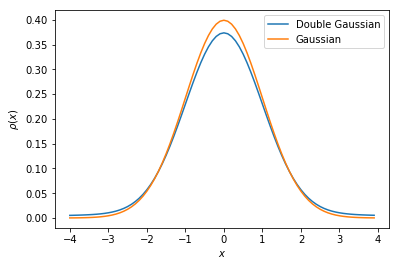

In [7]:
plt.plot(_x,d.density(_x),label='Double Gaussian')
plt.plot(_x,gaussian(x=_x,sigx=1,mux=0), label='Gaussian')
plt.legend()
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho(x)$')
plt.show()

### Tail content

Using the analytical expression, the tail content of a double Gaussian can be calculated as a function of $\sigma_2$ for

$$ A_1 = 0.95 \quad \quad \sigma_1 = 1 \, .$$

We compare with a numerical solution of the integral.

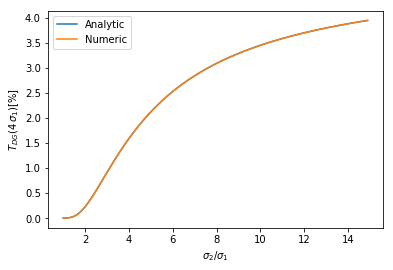

In [9]:
_data = []
for i in np.arange(1,15,0.1):
    d = dgauss(0.95,1.,i)
    _data.append([i, d.losses_above_nsig1(4), d.tailcontent(4)])
_data = pd.DataFrame(_data,columns=['x','numeric','analytic'])

plt.plot(_data.x,_data['analytic']*100,label='Analytic')
plt.plot(_data.x,_data['numeric']*100, label='Numeric')
plt.xlabel(r'$\sigma_2/\sigma_1$')
plt.ylabel(r'$T_{DG} (4 \, \sigma_1) [\%]$')
plt.legend()
plt.show()

Given the freedom in selecting the parameters $A_1$, $\sigma_1$ and $\sigma_2$, there is in principle an infinity of solutions matching the experimental findings 

$$1.9 \% \leq T(4\,\sigma) \leq 3.6 \%$$

All solutions can be displayed in a heat map in the $\sigma_2$, $A_2$ plane.

In [13]:
_data = []
for _a1 in np.arange(0.9,0.99,0.001):
    for _sig2 in np.arange(1,20,0.1):
        d = dgauss(a1=_a1, sig1=1, sig2=_sig2)       
        _data.append([_a1,_sig2,d.tailcontent(4)])
_data = pd.DataFrame(_data,columns=['a1','sig2','T'])

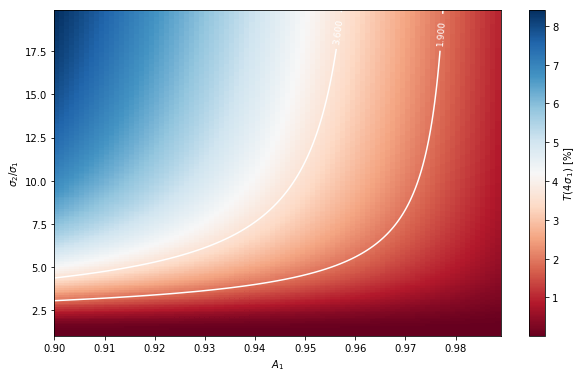

In [14]:
fig = plt.figure(figsize=[10,6])
ax1 = fig.add_subplot(111)

# prepare the colormes
X,Y,Z = prepare_pcolormesh(_data['a1'].values, _data['sig2'].values, _data['T'].values*100)

# plot the color mesh
im1 = ax1.pcolormesh(X,Y,Z, cmap=cm.RdBu, vmin=Z.min(), vmax=Z.max())
fig.colorbar(im1,label=r'$T(4\,\sigma_1)$ [%]')

# plot the limiting lines for 1.9 and 3.6 %
levels = np.array([1.9,3.6])
CS = ax1.contour(X,Y,Z, colors="white", levels=levels)
ax1.clabel(CS, fontsize=9, inline=1)

# ax1.set_ylim(1,5)
ax1.set_xlabel(r"$A_1$")
ax1.set_ylabel(r"$\sigma_2/\sigma_1$")
plt.show()

## Find solutions with $\sigma_1 \approx \sigma$

In [ ]:
_data = []
for _a1 in np.arange(0.9,0.99,0.001):
    for _sig2 in np.arange(1,20,0.1):
        d = dgauss(a1=_a1, sig1=1, sig2=_sig2)       
        _data.append([_a1,_sig2,d.tailcontent(4),d.integrate(boundaries=[[-np.inf,np.inf]],moment=2)**0.5])

In [ ]:
_data = pd.DataFrame(_data,columns=['a1','sig2','T','sig'])

Select the solutions with the correct tail content.

In [26]:
dists = _data[(_data['T']>0.019) & (_data['T']<0.036)]

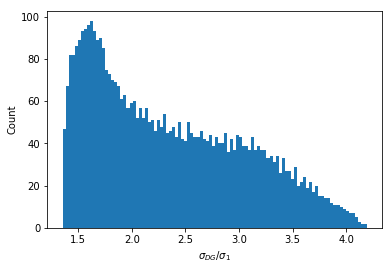

In [32]:
plt.hist(dists.sig,bins=100)
plt.xlabel(r'$\sigma_{DG}/\sigma_1$')
plt.ylabel('Count')
plt.show()

In [33]:
dists.sig.min(), dists.sig.mean()

(1.3533661736573741, 2.3440306021087527)

## Relation to Dynamic Aperture

With the data available from the measurements, all distributions with parameters in between the white lines are equally probable. If we want to relate dynamic aperture to beam loss we must take into account a representative set of the possible beam distributions and the beam loss as a function of the DA becomes a distribution as well.

In [98]:
# this dataframe contains all possible (phyical) solutions in the scanned range

_data = _data[(_data['T']>1.9e-2) & (_data['T']<3.6e-2)]         

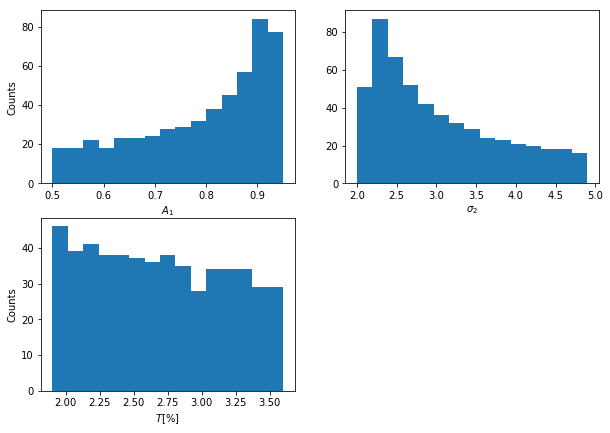

In [118]:
fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
# ax4 = fig.add_subplot(224)

ax1.hist(_data.a1,bins=15)
ax2.hist(_data.sig2,bins=15)
ax3.hist(_data['T']*100,bins=15)

ax1.set_xlabel(r'$A_1$')
ax2.set_xlabel(r'$\sigma_2$')
ax3.set_xlabel(r'$T [\%]$')

for ax in [ax1,ax3]:
    ax.set_ylabel('Counts')

plt.show()

The loss $L$ as a function of the dynamic aperture $D$ for a given double Gaussian distribution, defined by $A_1,\sigma_2$, is given by the integral:

$$ L(D,A_1,\sigma_2) = 2 \, \int_{D}^{\infty} \rho_{DG}(x,A_1,\sigma_2) dx .$$
With the distribution of double Gaussian parameters, we can deduce a range of possible loss values as a function of the dynamic aperture:

In [164]:
physical_dgauss_params = _data    # assign the set of physical dgaussian functions to a new variable

In [131]:
def get_loss_from_da(da):
    '''Returns the minimum,maximum and mean expectable loss for a given DA'''
    
    loss = []
    for _, line in physical_dgauss_params.head().iterrows():
        _a1, _sig2 = line['a1'], line['sig2']
        
        # initialize the gaussian
        dg = dgauss(a1=_a1,sig1=1,sig2=_sig2)
        
        # append the relevant quantities
        loss.append([_a1,_sig2,dg.integrate([[da,np.inf]])])
        
    loss = pd.DataFrame(loss,columns=['a1','sig2','loss'])
    
    return loss.loss.min(), loss.loss.max(), loss.loss.mean()

In [142]:
_losses = []
for _da in np.arange(1,12,0.1):
    _minl, _maxl, _avgl = get_loss_from_da(_da)
    _losses.append([_da, _minl, _maxl, _avgl])
_losses = pd.DataFrame(_losses, columns=['da','minl','maxl','avgl'])

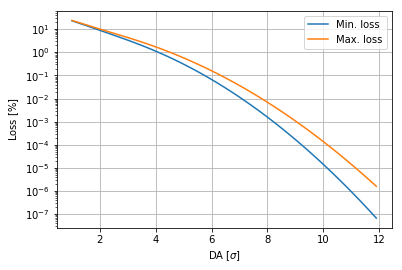

In [149]:
plt.plot(_losses.da,_losses.minl*1e2,label='Min. loss')
plt.plot(_losses.da,_losses.maxl*1e2,label='Max. loss')
plt.xlabel(r'DA [$\sigma$]')
plt.ylabel(r'Loss [$\%$]')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

With this curve, the DA can be related to losses. Let's save the dataframe to an HDF file to be able to use it afterwards.

In [156]:
hdf = pd.HDFStore('resources/distributions.h5')
hdf.put('physical_dgauss_params',physical_dgauss_functions,format='table',data_columns=True)
hdf.close()

The parameters for the physical beam distributions can be loaded from this HDF file.

In [159]:
hdf = pd.HDFStore('resources/distributions.h5')

In [163]:
hdf['physical_dgauss_params'].head()

,a1,sig2,T
0,0.500,2.0,0.022782
1,0.500,2.1,0.028437
2,0.500,2.2,0.034550
3,0.505,2.0,0.022555
4,0.505,2.1,0.028153


# Usage in other python scripts

In [3]:
import sixdesk.dist as dist

In [4]:
dist.get_loss_from_da(10)

(1.4189256221104931e-07, 1.3704206552376231e-06, 5.219433046869815e-07)